# iCAT world
---

#### Overview
Notebook to create stacks of tile specifications in "real-world" or "physical" coordinate space (aka microns). This is to facilitate `5_iCAT-correlate.ipynb` as there is otherwise no way of knowing _a priori_ which high-mag EM tiles overlap with each low-mag EM tile.

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up environment
---

In [3]:
import renderapi
from icatapi.render_pandas import create_stacks_DataFrame

In [4]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'pancreas'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'pancreas',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [6]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

# Output
# ------
out = f"""\
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
stacks = ['EM_lomag', 'EM_himag']
df_project = create_stacks_DataFrame(stacks=stacks,
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

all stacks.......... ['EM_lomag_overlaid', 'AF594_overlaid', 'Hoechst_overlaid', 'EM_himag_stitched', 'EM_himag_montaged', 'Hoechst', 'EM_lomag', 'EM_himag', 'AF594']
EM stacks........... ['EM_lomag_overlaid', 'EM_himag_stitched', 'EM_himag_montaged', 'EM_lomag', 'EM_himag']
FM stacks........... ['AF594_overlaid', 'Hoechst_overlaid', 'Hoechst', 'AF594']
...



tileId    z   width  height   minint   maxint  \
stack                                                                
EM_himag 90  aal_lil_EM-...  7.0  4096.0  4096.0  31112.0  33082.0   
         27  aax_lil_EM-...  4.0  4096.0  4096.0  31039.0  32893.0   
         52  aax_lil_EM-...  5.0  4096.0  4096.0  30825.0  32870.0   
EM_lomag 2   aaa_big_EM-...  6.0  4096.0  4096.0  31639.0  34260.0   
         3   aaa_big_EM-...  7.0  4096.0  4096.0  31681.0  34238.0   
         1   aaa_big_EM-...  5.0  4096.0  4096.0  31586.0  34319.0   

                   imageUrl          tforms     stack sectionId  imageRow  \
stack                                                                       
EM_himag 90  https://son...  [M=[[1.0000...  EM_himag      S007         4   
         27  https://son...  [M=[[1.0000...  EM_himag      S004         2   
         52  https://son...  [M=[[1.0000...  EM_himag      S005         2   
EM_lomag 2   https://son...  [M=[[1.0000...  EM_lomag      S006         1   
         3   https://son...  [M=[[1.0000...  EM_lomag      S007         1   
         1   https://son...  [M=[[1.0000...  EM_lomag      S005         1   

             imageCol    stageX    stageY  
stack                                      
EM_himag 90         5  2856.559  6365.238  
         27         3  1025.905  6405.822  
         52         3  1622.883  6413.467  
EM_lomag 2          1  2226.245  6381.133  
         3          1  2831.405  6381.305  
         1          1  1621.125  6381.079

## Create world stacks
---

In [21]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.overlay import get_transform_metadata
from icatapi.render_pandas import create_stack_from_DataFrame

In [22]:
channel_map = {
    'EM_lomag': 'Secondary electrons',
    'EM_himag': 'Secondary electrons'
}

# Loop through stacks
for stack, df_stack in tqdm(df_project.groupby('stack')):

    # Loop through tiles
    for i, tile in df_stack.iterrows():

        # Get transform metadata
        fp = Path(tile['imageUrl'].split('.nl')[1])
        tform_md = get_transform_metadata(fp)
        channel_name = channel_map[fp.parents[1].name]
        pixelsize, rotation, shear, translation = tform_md[channel_name]

        # Convert from metres to microns
        pixelsize = [1e6*ps for ps in pixelsize]      # m --> um
        translation = [1e6*tr for tr in translation]  # m --> um

        # Create transform
        w = tile['width']
        h = tile['height']
        T = AffineMPL().translate(-w/2, -h/2)\
                       .scale(*pixelsize)\
                       .rotate(rotation)\
                       .skew(shear, 0)\
                       .translate( translation[0],
                                  -translation[1])
        A = AffineRender()
        A.M = T.get_matrix()

        # Replace transform in DataFrame
        df_stack.at[i, 'tforms'] = [A]

    # Create world stack
    stack_world = f"{stack}_world"
    create_stack_from_DataFrame(df=df_stack,
                                name=stack_world,
                                render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for EM_himag_world...
Importing tile specifications to EM_himag_world...
Stack EM_himag_world created successfully.
Creating tile specifications for EM_lomag_world...
Importing tile specifications to EM_lomag_world...
Stack EM_lomag_world created successfully.


## Inspect stacks
---

In [26]:
from icatapi.plotting import plot_tile_map, plot_stacks

### Project DataFrame

In [23]:
# Project DataFrame
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_world = [stack for stack in stacks if 'world' in stack]
df_world = create_stacks_DataFrame(stacks=stacks_world,
                                   render=render)

df_world.groupby('stack')\
        .apply(lambda x: x.sample(3))

tileId    z   width  height   minint   maxint  \
stack                                                                      
EM_himag_world 67  aan_lil_EM-...  6.0  4096.0  4096.0  30931.0  32897.0   
               11  aah_lil_EM-...  4.0  4096.0  4096.0  31039.0  32893.0   
               72  aas_lil_EM-...  6.0  4096.0  4096.0  30931.0  32897.0   
EM_lomag_world 2   aaa_big_EM-...  6.0  4096.0  4096.0  31639.0  34260.0   
               3   aaa_big_EM-...  7.0  4096.0  4096.0  31681.0  34238.0   
               0   aaa_big_EM-...  4.0  4096.0  4096.0  31678.0  34295.0   

                         imageUrl          tforms           stack sectionId  \
stack                                                                         
EM_himag_world 67  https://son...  [M=[[0.0048...  EM_himag_world      S006   
               11  https://son...  [M=[[0.0048...  EM_himag_world      S004   
               72  https://son...  [M=[[0.0048...  EM_himag_world      S006   
EM_lomag_world 2   https://son...  [M=[[0.0339...  EM_lomag_world      S006   
               3   https://son...  [M=[[0.0339...  EM_lomag_world      S007   
               0   https://son...  [M=[[0.0339...  EM_lomag_world      S004   

                   imageRow  imageCol    stageX    stageY  
stack                                                      
EM_himag_world 67         4         3  2232.626  6380.863  
               11         5         4  1043.977  6353.055  
               72         3         5  2268.491  6398.381  
EM_lomag_world 2          1         1  2226.245  6381.133  
               3          1         1  2831.405  6381.305  
               0          1         1  1021.110  6371.003

### Map out tiles in `render` space

  0%|          | 0/4 [00:00<?, ?it/s]

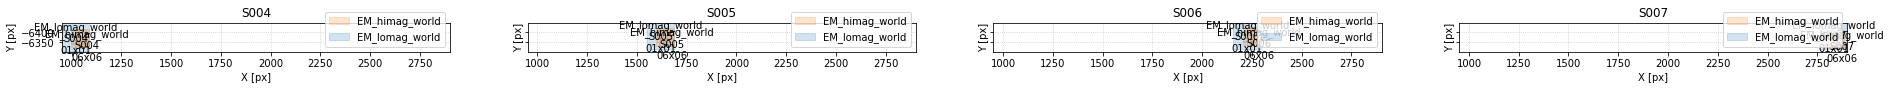

In [27]:
# Set stacks to plot
stacks_2_plot = stacks_world

# Plot tile map
plot_tile_map(stacks_2_plot, render=render)

### Plot stacks

  0%|          | 0/8 [00:00<?, ?it/s]

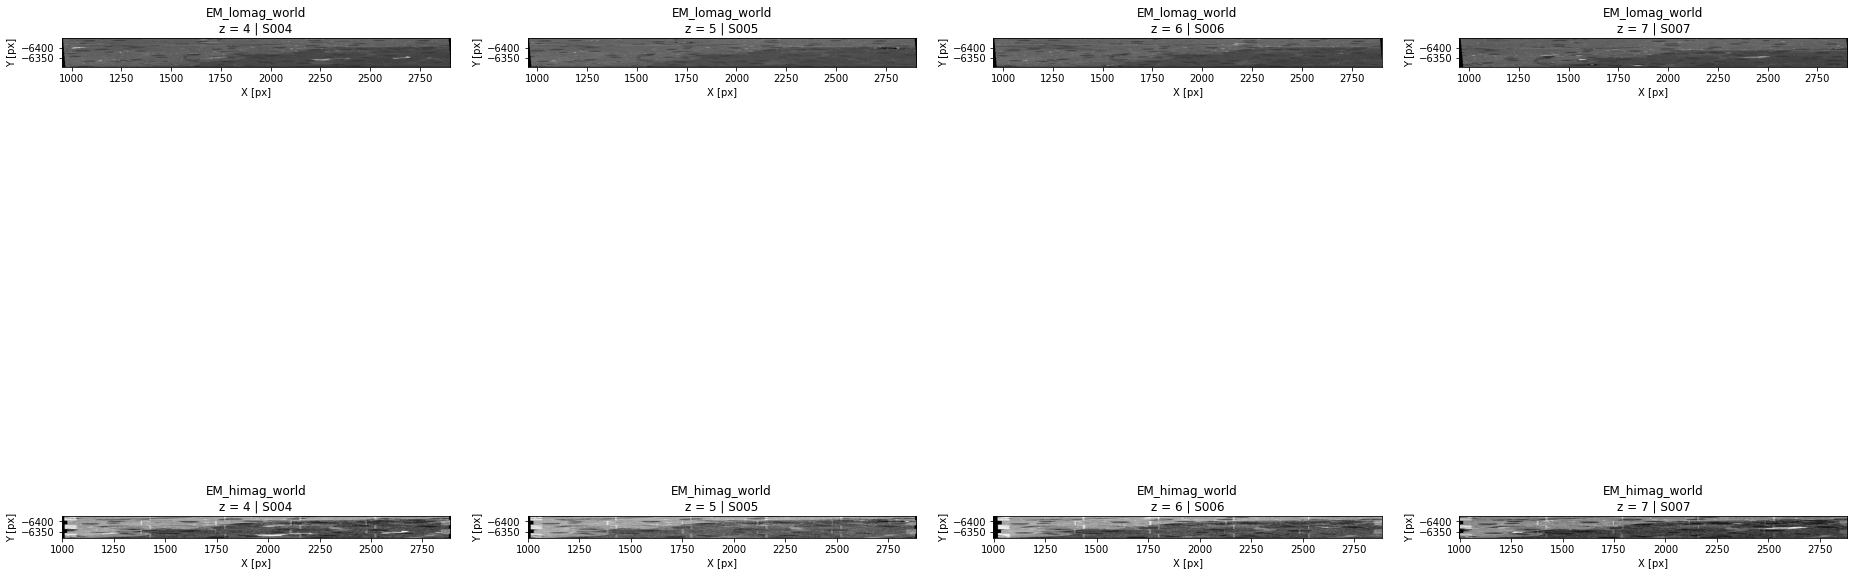

In [28]:
stacks_2_plot = stacks_world

plot_stacks(stacks=stacks_2_plot,
            maxTileSpecsToRender=30,
            render=render)